## imports

In [ ]:
pip install py7zr

In [ ]:
import os
import requests
import py7zr
import pandas as pd

import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import cv2

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset, Subset
from copy import deepcopy

from sklearn.metrics import classification_report
from tqdm.notebook import tqdm

In [ ]:
torch.manual_seed(0)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

data_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

cpu


## get and read data

In [ ]:
# download zip

if not os.path.exists("SCDB.7z"):
  url = "https://cloud.dfki.de/owncloud/index.php/s/DeHxejXFekTM2KW/download"
  r = requests.get(url, allow_redirects=True)
  open("SCDB.7z", 'wb').write(r.content)
  print('zip downloaded')
else:
  print('zip already exists')


# extract folder from zip
if not os.path.exists("SCDB-7M (Kopie)"):
  with py7zr.SevenZipFile('SCDB.7z', mode='r') as z:
    z.extractall()
  print('folder extracted from zip')
else:
  print('zip already extracted')

zip already exists
zip already extracted


In [ ]:
root_dir = "SCDB-7M (Kopie)"

train_labels = pd.read_csv(root_dir + "/train.csv", header=None)
val_labels = pd.read_csv(root_dir + "/val.csv", header=None)
test_labels = pd.read_csv(root_dir + "/test.csv", header=None)

# sort so that labels matches the images
# extract labels, convert to np array
train_labels = np.array([int(label.split('|',1)[1]) for label in sorted(train_labels[0])])
val_labels = np.array([int(label.split('|',1)[1]) for label in sorted(val_labels[0])])
test_labels = np.array([int(label.split('|',1)[1]) for label in sorted(test_labels[0])])

In [ ]:
def getImgs(d_type):
  imgs = []
  files = sorted(os.listdir(root_dir+'/'+d_type))
  for file in files:
    imgs.append (Image.open(root_dir+'/'+d_type+'/'+file))
  return imgs

train_inputs = getImgs("train")
val_inputs = getImgs("val")
test_inputs = getImgs("test")

## create dataset and dataloader

In [ ]:
# custom dataset class
class mydataset(Dataset):
  def __init__(self, inputs, labels, transform):
    self.inputs = inputs
    self.labels = labels
    self.transform = transform

  def __len__(self):
    return len(self.inputs)

  def __getitem__(self, index):
    input = self.transform(self.inputs[index])
    label = self.labels[index]
    return input,label


train_dataset = mydataset(train_inputs, train_labels, transform = data_transforms)
train_loader = DataLoader(train_dataset, batch_size=50, shuffle=True)

val_dataset = mydataset(val_inputs, val_labels, transform = data_transforms)
val_loader = DataLoader(val_dataset, batch_size=50, shuffle=False)

test_dataset = mydataset(test_inputs, test_labels, transform = data_transforms)
test_loader = DataLoader(test_dataset, batch_size=50, shuffle=False)

## override the network for accessing gradients

In [ ]:
# view the model architecture
print(torch.hub.load('pytorch/vision:v0.9.0', 'mobilenet_v2', pretrained=True))

MobileNetV2(
  (features): Sequential(
    (0): ConvBNActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=1e-05, momen

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.9.0


In [ ]:
class MobileNetV2(nn.Module):
    def __init__(self):
        super(MobileNetV2, self).__init__()
        
        # get the pretrained mnv2 network
        self.mnv2 = torch.hub.load('pytorch/vision:v0.9.0', 'mobilenet_v2', pretrained=True)
        
        # disect the network to access its last convolutional layer
        self.features_conv = self.mnv2.features[:19]
        
        # get the classifier of the mnv2
        self.classifier = self.mnv2.classifier
        
        # placeholder for the gradients
        self.gradients = None
    
    # hook for the gradients of the activations
    def activations_hook(self, grad):
        self.gradients = grad
        
    def forward(self, x):
        x = self.features_conv(x)
        
        # register the hook
        if x.requires_grad:
          h = x.register_hook(self.activations_hook)

        # Cannot use "squeeze" as batch-size can be 1
        x = nn.functional.adaptive_avg_pool2d(x, (1, 1))
        x = torch.flatten(x, 1)

        x = self.classifier(x)
        return x
    
    # method for the gradient extraction
    def get_activations_gradient(self):
        return self.gradients
    
    # method for the activation exctraction
    def get_activations(self, x):
        return self.features_conv(x)

## define train function

In [ ]:
def trainNet(net,criterion,optimizer,scheduler,train_loader,val_loader,epochs,check_every=None,earlyStopping=False):

  print("training network")

  if not check_every:
      check_every = int(epochs / 10) if epochs > 10 else 1

  avg_trainLosses = []
  avg_valLosses = []

  for epoch in tqdm(range(epochs)):  # loop over the dataset multiple times

    train_loss = []
    val_loss = []

    net.train()
    for i, (inputBatch,labelBatch) in enumerate(tqdm(train_loader, leave=False)):

        inputBatch = inputBatch.to(device)
        labelBatch = labelBatch.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward
        outputBatch = net(inputBatch)
        loss = criterion(outputBatch, labelBatch)
        train_loss.append(loss.item())

        # backward + optimize
        loss.backward()
        optimizer.step()
    scheduler.step()


    net.eval()
    for i, (inputBatch,labelBatch) in enumerate(tqdm(val_loader, leave=False)):
      with torch.no_grad():

        inputBatch = inputBatch.to(device)
        labelBatch = labelBatch.to(device)

        # forward
        outputBatch = net(inputBatch)
        loss = criterion(outputBatch, labelBatch)
        val_loss.append(loss.item())

    avg_trainLoss = np.mean(train_loss)
    avg_valLoss = np.mean(val_loss)
    avg_trainLosses.append(avg_trainLoss)

    if epoch > 0:
      if avg_valLoss < min(avg_valLosses):
        best_params = deepcopy(net.state_dict())
        best_epoch, best_loss = epoch, avg_valLoss
    else:
      movAvg_old = avg_valLoss    
    avg_valLosses.append(avg_valLoss)   

    # print statistics
    if epoch % check_every == check_every - 1:
      print('epoch: %d  | train loss: %.3f, val loss: %.3f' % (epoch + 1, avg_trainLoss, avg_valLoss), end="  | ")
      movAvg_new = np.mean(avg_valLosses[epoch+1-check_every:epoch+1])
      print('avg train loss: %.3f, avg val loss: %.3f' % (np.mean(avg_trainLosses[epoch+1-check_every:epoch+1]), movAvg_new))

      if earlyStopping:
        if movAvg_old < movAvg_new:
          break
        else:
          movAvg_old = movAvg_new



  last_params = deepcopy(net.state_dict())
  print('Finished Training')
  plt.plot(avg_trainLosses, label='train loss')
  plt.plot(avg_valLosses, label='val loss')
  #plt.plot([best_loss]*epoch, linestyle='dashed')
  plt.plot(best_epoch, best_loss, 'o')
  plt.xlabel("epoch")
  plt.ylabel("loss")
  plt.legend()
  plt.show()

  return best_params, last_params

In [ ]:
#model = torch.hub.load('pytorch/vision:v0.9.0', 'mobilenet_v2', pretrained=True).to(device)
model = MobileNetV2().to(device)

# make last layer to have only 2 out_features instead of 1000
#model.classifier[1] = torch.nn.Linear(in_features=model.classifier[1].in_features, out_features=2).to(device)

#Define a Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
# Decay LR by a factor of 0.1 every 7 epochs
scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.9.0


training network


epoch: 3  | train loss: 0.455, val loss: 0.735  | avg train loss: 1.867, avg val loss: 0.830


epoch: 6  | train loss: 0.083, val loss: 0.665  | avg train loss: 0.191, avg val loss: 0.633


epoch: 9  | train loss: 0.032, val loss: 0.581  | avg train loss: 0.059, avg val loss: 0.599


epoch: 12  | train loss: 0.030, val loss: 0.582  | avg train loss: 0.027, avg val loss: 0.587


epoch: 15  | train loss: 0.029, val loss: 0.582  | avg train loss: 0.027, avg val loss: 0.584


epoch: 18  | train loss: 0.018, val loss: 0.582  | avg train loss: 0.023, avg val loss: 0.589



Finished Training


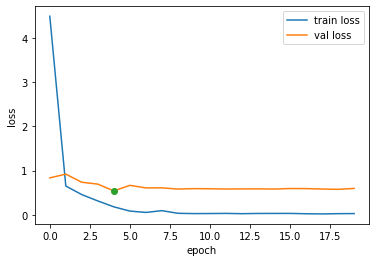

In [ ]:
best_params, last_params = trainNet(model, criterion, optimizer, scheduler, train_loader, val_loader, epochs=20, check_every=3)

In [ ]:
model.load_state_dict(best_params)
torch.save(model.state_dict(), "chpnt.pt")

In [ ]:
model.load_state_dict(torch.load("chpnt.pt", map_location=torch.device('cpu')))

<All keys matched successfully>

## evaluate

In [ ]:
def evaluate(net, loader):

  net.eval()
  output_pred = []
  output_true = []

  for i, (inputBatch,labelBatch) in enumerate(tqdm(loader)):
    with torch.no_grad():

      inputBatch = inputBatch.to(device)
      labelBatch = labelBatch.to(device)

      # forward
      outputBatch = net(inputBatch)
      for output, label in zip(outputBatch,labelBatch):
        output_true.append(label.cpu().numpy())
        val, indx = torch.max(output,0)
        output_pred.append(indx.cpu().numpy())

  print(classification_report(output_true, output_pred, digits=4))

In [ ]:
print("evaluation results on train data")
evaluate(model,train_loader)
print("evaluation results on test data")
evaluate(model,test_loader)

evaluation results on train data



              precision    recall  f1-score   support

           0     0.9832    0.9750    0.9791       480
           1     0.9752    0.9833    0.9793       480

    accuracy                         0.9792       960
   macro avg     0.9792    0.9792    0.9792       960
weighted avg     0.9792    0.9792    0.9792       960

evaluation results on test data



              precision    recall  f1-score   support

           0     0.7190    0.7333    0.7261       150
           1     0.7279    0.7133    0.7205       150

    accuracy                         0.7233       300
   macro avg     0.7234    0.7233    0.7233       300
weighted avg     0.7234    0.7233    0.7233       300



## grad cam

reference : https://medium.com/@stepanulyanin/implementing-grad-cam-in-pytorch-ea0937c31e82

In [ ]:
def displaySaliencyMaps(model, n_samples=5):

  # set the evaluation mode
  model.eval()
  my_subset = Subset(test_dataset, list(range(n_samples)))
  imgs = sorted(os.listdir("./SCDB-7M (Kopie)/test"))[:n_samples]

  fig, axs = plt.subplots(3,5, figsize=(15,15))
  for indx, (img_name, (input,label)) in tqdm(enumerate(zip(imgs,my_subset)), total=n_samples):

    # unsqueeze to add an extra dimension for batch
    input = input.unsqueeze(0)

    # get the logits
    pred = model(input)
    pred_class = pred.argmax(dim=1)[0]
    
    # grad wrt to predicted class
    pred[:, pred_class].backward()

    # pull the gradients out of the model
    gradients = model.get_activations_gradient()

    # pool the gradients across the channels
    pooled_gradients = torch.mean(gradients, dim=[0, 2, 3])

    # get the activations of the last convolutional layer
    activations = model.get_activations(input).detach()

    # weight the channels by corresponding gradients
    for i in range(512):
        activations[:, i, :, :] *= pooled_gradients[i]
        
    # average the channels of the activations
    heatmap = torch.mean(activations, dim=1).squeeze()

    # relu on top of the heatmap
    # expression (2) in https://arxiv.org/pdf/1610.02391.pdf
    heatmap = np.maximum(heatmap, 0)

    # normalize the heatmap
    heatmap /= torch.max(heatmap)

    # draw the heatmap
    axs[1][indx].matshow(heatmap.squeeze())


    img = cv2.imread("./SCDB-7M (Kopie)/test/" + img_name)
    axs[0][indx].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

    heatmap = cv2.resize(heatmap.numpy(), (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    superimposed_img = heatmap * 0.4 + img
    cv2.imwrite('./map.jpg', superimposed_img)

    superimposed_img = cv2.cvtColor(np.float32(np.clip(superimposed_img/255,0,1)), cv2.COLOR_BGR2RGB)
    axs[2][indx].imshow(superimposed_img)

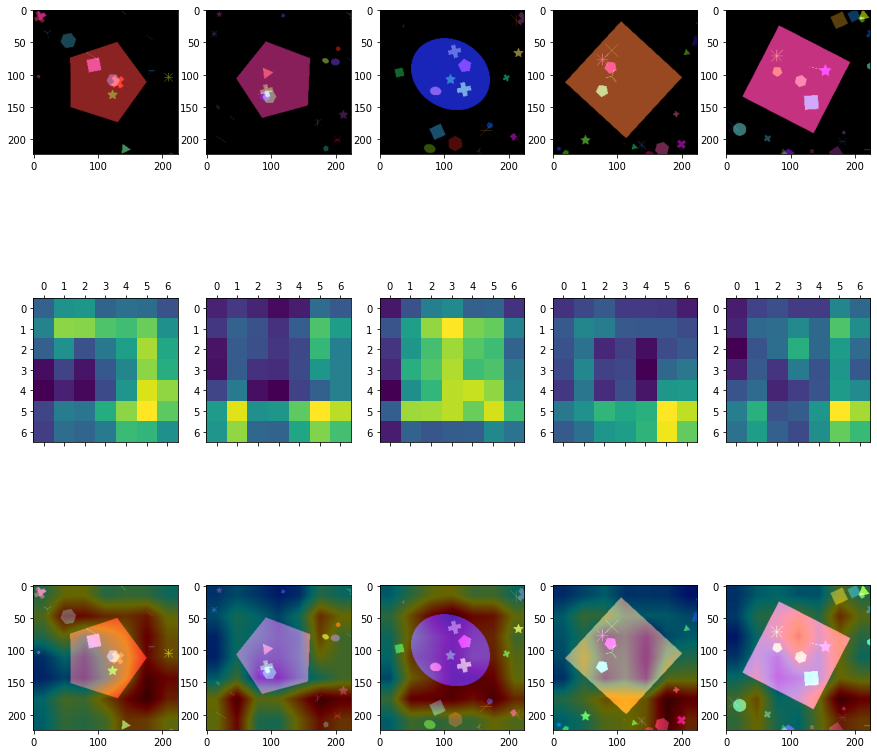

In [ ]:
displaySaliencyMaps(model)